# Predictive model for classification

In [1]:
import pandas as pd

DATA = "../data/customers_clustered.csv"

df_clustered = pd.read_csv(DATA)
df_clustered.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,2


In [2]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2205 non-null   object 
 1   Marital_Status       2205 non-null   object 
 2   Income               2205 non-null   float64
 3   Kidhome              2205 non-null   int64  
 4   Teenhome             2205 non-null   int64  
 5   Recency              2205 non-null   int64  
 6   MntWines             2205 non-null   int64  
 7   MntFruits            2205 non-null   int64  
 8   MntMeatProducts      2205 non-null   int64  
 9   MntFishProducts      2205 non-null   int64  
 10  MntSweetProducts     2205 non-null   int64  
 11  MntGoldProds         2205 non-null   int64  
 12  NumDealsPurchases    2205 non-null   int64  
 13  NumWebPurchases      2205 non-null   int64  
 14  NumCatalogPurchases  2205 non-null   int64  
 15  NumStorePurchases    2205 non-null   i

In [3]:
X = df_clustered.drop("Response", axis=1)
y = df_clustered["Response"]

In [4]:
X.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,2


In [5]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Response, dtype: int64

In [6]:
one_hot_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
    "cluster"
]

standard_cols = [
    "Income",
    "Age",
]

power_cols = X.columns[
   X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()

minmax_cols = [
    col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols
]

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

**ALUNOS**: Expliquem brevemente cada modelo e o papel do DummyClassifier. Expliquem o papel da função e de cada etapa do pipeline.

In [7]:
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline  # atenção para o Pipeline do ImbLearn
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

RANDOM_STATE = 42

models = {
    "DummyClassifier": DummyClassifier(
        strategy="stratified", random_state=RANDOM_STATE
    ),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "KNNClassifier": KNeighborsClassifier(n_neighbors=5),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


def pipeline_model(X, y, model, kf):
    preprocessing = ColumnTransformer(
        [
            ("one-hot", OneHotEncoder(), one_hot_cols),
            ("standard", StandardScaler(), standard_cols),
            ("minmax", MinMaxScaler(), minmax_cols),
            ("power", PowerTransformer(), power_cols),
        ]
    )

    pipeline = Pipeline(
        [
            ("preprocessing", preprocessing),
            ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
            ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
            ("model", model),
        ]
    )

    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
        n_jobs=-1,
    )

    return scores

In [8]:
results = {
    "DummyClassifier": pipeline_model(X, y, models["DummyClassifier"], skf),
    "DecisionTreeClassifier": pipeline_model(X, y, models["DecisionTreeClassifier"], skf),
    "LogisticRegression": pipeline_model(X, y, models["LogisticRegression"], skf),
    "KNNClassifier": pipeline_model(X, y, models["KNNClassifier"], skf),
}

**ALUNOS**: Expliquem a estrutura dos resultados

In [9]:
from pprint import pprint

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.05351782, 0.05652118, 0.0586369 , 0.05717325, 0.0555172 ]),
                            'score_time': array([0.02500582, 0.02500558, 0.0230062 , 0.0230062 , 0.02300525]),
                            'test_accuracy': array([0.82539683, 0.82993197, 0.82993197, 0.81179138, 0.6893424 ]),
                            'test_average_precision': array([0.3683831 , 0.38016844, 0.3602606 , 0.43117226, 0.22619856]),
                            'test_precision': array([0.43243243, 0.44444444, 0.44871795, 0.40229885, 0.26797386]),
                            'test_recall': array([0.47761194, 0.47761194, 0.52238806, 0.53030303, 0.62121212]),
                            'test_roc_auc': array([0.68534999, 0.70773805, 0.73826722, 0.71830303, 0.66331313])},
 'DummyClassifier': {'fit_time': array([0.06235242, 0.06004643, 0.05734229, 0.05603647, 0.06604815]),
                     'score_time': array([0.02356434, 0.02305984, 0.02206874, 0.02507019, 0.02548385

In [10]:
for k, v in results.items():
    results[k]["time"] = results[k]["fit_time"] + results[k]["score_time"]

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.05351782, 0.05652118, 0.0586369 , 0.05717325, 0.0555172 ]),
                            'score_time': array([0.02500582, 0.02500558, 0.0230062 , 0.0230062 , 0.02300525]),
                            'test_accuracy': array([0.82539683, 0.82993197, 0.82993197, 0.81179138, 0.6893424 ]),
                            'test_average_precision': array([0.3683831 , 0.38016844, 0.3602606 , 0.43117226, 0.22619856]),
                            'test_precision': array([0.43243243, 0.44444444, 0.44871795, 0.40229885, 0.26797386]),
                            'test_recall': array([0.47761194, 0.47761194, 0.52238806, 0.53030303, 0.62121212]),
                            'test_roc_auc': array([0.68534999, 0.70773805, 0.73826722, 0.71830303, 0.66331313]),
                            'time': array([0.07852364, 0.08152676, 0.0816431 , 0.08017945, 0.07852244])},
 'DummyClassifier': {'fit_time': array([0.06235242, 0.06004643, 0.05734229, 0.05603647, 0.0660481

**ALUNOS**: Expliquem os procedimentos para gerar o DataFrame com os resultados.

In [11]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns={"index": "model"})
df_results

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,"[0.06235241889953613, 0.06004643440246582, 0.0...","[0.02356433868408203, 0.023059844970703125, 0....","[0.5124716553287982, 0.5034013605442177, 0.503...","[0.1542056074766355, 0.14485981308411214, 0.14...","[0.4925373134328358, 0.4626865671641791, 0.462...","[0.5042900470907494, 0.4866908771649773, 0.486...","[0.15304952129175473, 0.14865734269715697, 0.1...","[0.08591675758361816, 0.08310627937316895, 0.0..."
1,DecisionTreeClassifier,"[0.053517818450927734, 0.05652117729187012, 0....","[0.025005817413330078, 0.025005578994750977, 0...","[0.8253968253968254, 0.8299319727891157, 0.829...","[0.43243243243243246, 0.4444444444444444, 0.44...","[0.47761194029850745, 0.47761194029850745, 0.5...","[0.6853499880277755, 0.7077380477292681, 0.738...","[0.3683830979533475, 0.38016844076749257, 0.36...","[0.07852363586425781, 0.0815267562866211, 0.08..."
2,LogisticRegression,"[0.06331110000610352, 0.06290769577026367, 0.0...","[0.02791905403137207, 0.023897886276245117, 0....","[0.7845804988662132, 0.8299319727891157, 0.829...","[0.35106382978723405, 0.4444444444444444, 0.45...","[0.4925373134328358, 0.47761194029850745, 0.53...","[0.6857091547609545, 0.7083167052438343, 0.738...","[0.3819814120613085, 0.41502673077110863, 0.36...","[0.09123015403747559, 0.08680558204650879, 0.0..."
3,KNNClassifier,"[0.04813838005065918, 0.05732417106628418, 0.0...","[0.040640830993652344, 0.046417951583862305, 0...","[0.8503401360544217, 0.8526077097505669, 0.854...","[0.5172413793103449, 0.5333333333333333, 0.565...","[0.22388059701492538, 0.23880597014925373, 0.1...","[0.6013049724638838, 0.6030010375927847, 0.606...","[0.2835258077353654, 0.3012183978068839, 0.252...","[0.08877921104431152, 0.10374212265014648, 0.1..."


In [12]:
df_results.columns[1:].to_list()

['fit_time',
 'score_time',
 'test_accuracy',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision',
 'time']

In [13]:
df_results.columns[3:].to_list()

['test_accuracy',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision',
 'time']

In [14]:
df_results_explode = df_results.explode(
    df_results.columns[1:].to_list()
).reset_index(drop=True)

df_results_explode

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,0.062352,0.023564,0.512472,0.154206,0.492537,0.50429,0.15305,0.085917
1,DummyClassifier,0.060046,0.02306,0.503401,0.14486,0.462687,0.486691,0.148657,0.083106
2,DummyClassifier,0.057342,0.022069,0.503401,0.14486,0.462687,0.486691,0.148657,0.079411
3,DummyClassifier,0.056036,0.02507,0.487528,0.126168,0.409091,0.455212,0.14005,0.081107
4,DummyClassifier,0.066048,0.025484,0.510204,0.149533,0.484848,0.499758,0.149598,0.091532
5,DecisionTreeClassifier,0.053518,0.025006,0.825397,0.432432,0.477612,0.68535,0.368383,0.078524
6,DecisionTreeClassifier,0.056521,0.025006,0.829932,0.444444,0.477612,0.707738,0.380168,0.081527
7,DecisionTreeClassifier,0.058637,0.023006,0.829932,0.448718,0.522388,0.738267,0.360261,0.081643
8,DecisionTreeClassifier,0.057173,0.023006,0.811791,0.402299,0.530303,0.718303,0.431172,0.080179
9,DecisionTreeClassifier,0.055517,0.023005,0.689342,0.267974,0.621212,0.663313,0.226199,0.078522


**ALUNOS**: Expliquem os gráficos e como eles levaram à seleção do LogisticRegression.

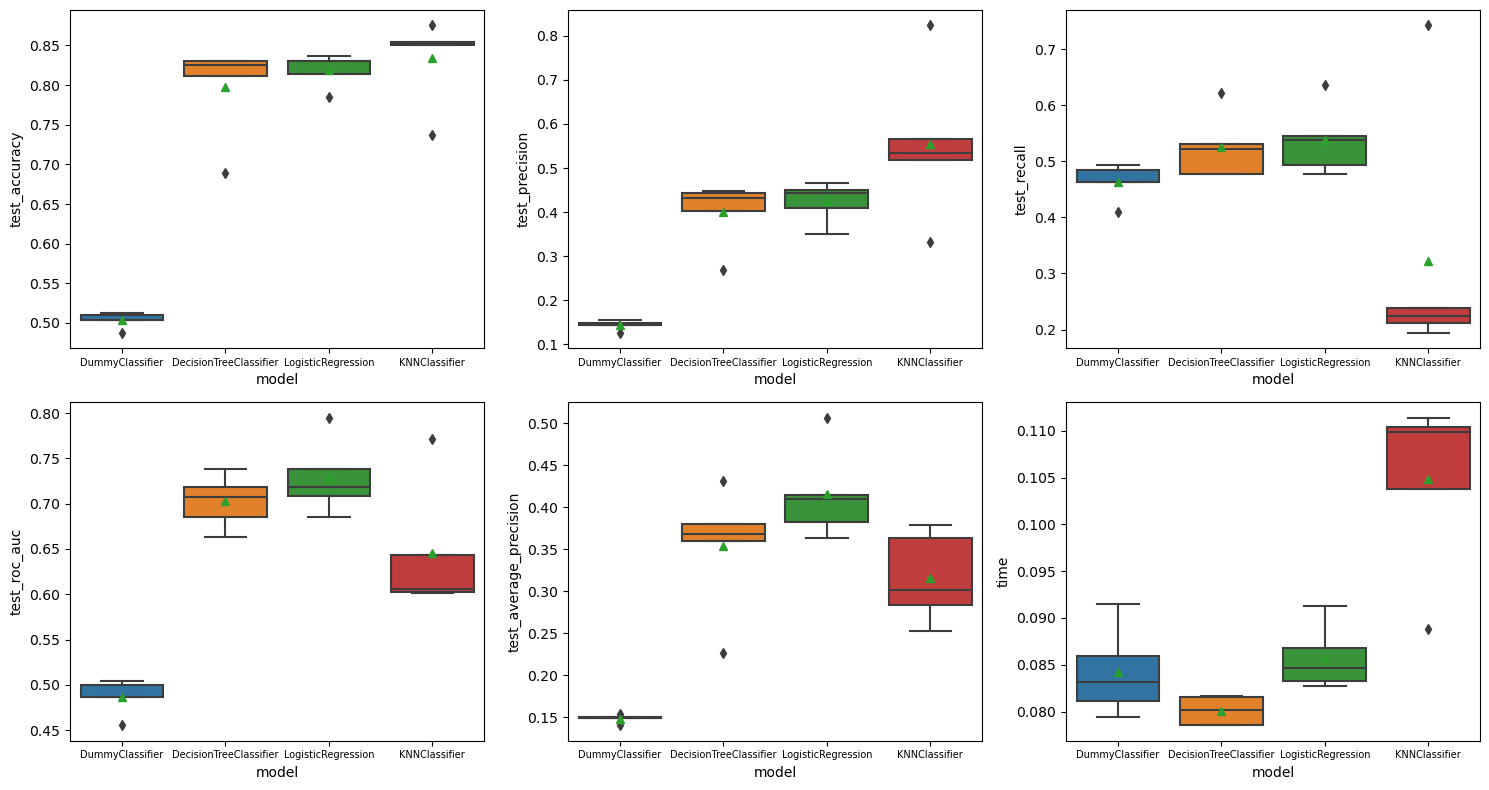

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), tight_layout=True)

cols = df_results.columns[3:].to_list()

for ax, col in zip(axs.flatten(), cols):
    b = sns.boxplot(x="model", y=col, data=df_results_explode, ax=ax, showmeans=True)
    b.set_xticklabels(b.get_xticklabels(), fontsize=7)

plt.show()